In [1]:
import os, sys
import geopandas as gpd
import pandas as pd
import rasterio as rio
import numpy as np
from shapely.geometry import Point
import skimage.graph as graph

In [2]:
input_dir = "/home/public/Data/PROJECTS/Health" #
out_folder = "/home/wb514197/data/health"
# if not os.path.exists(out_folder):
#     os.mkdir(out_folder)

In [3]:
lbr_raw = pd.read_csv(os.path.join(input_dir, "from_tashrik", "hierarchy", "raw_liberia_collapsed.csv"))

In [4]:
len(lbr_raw)

936

In [5]:
lbr_master = pd.read_excel(os.path.join(input_dir, "from_tashrik", "master lists", "Liberia.xlsx"))

In [6]:
lbr_master['Status'] = lbr_master['Status'].apply(lambda x: x.lower())
lbr_master['HF Type'] = lbr_master['HF Type'].apply(lambda x: x.lower())

In [7]:
lbr_master.Status.value_counts()

functional        699
non-functional     54
Name: Status, dtype: int64

In [14]:
lbr = lbr_master.loc[lbr_master.Status!="non-functional"].copy()

In [15]:
lbr.Status.value_counts()

functional    699
Name: Status, dtype: int64

In [16]:
lbr[['HF Type']].value_counts()

HF Type      
clinic           607
health center     56
hospital          36
dtype: int64

In [17]:
lbr[['Lat']].isna().value_counts()

Lat  
False    627
True      72
dtype: int64

In [18]:
lbr = lbr.loc[~lbr.Lat.isna()].copy()

In [19]:
lbr[['HF Type']].value_counts()

HF Type      
clinic           538
health center     53
hospital          36
dtype: int64

In [20]:
geoms = [Point(xy) for xy in zip(lbr.Long, lbr.Lat)]

In [21]:
lbr_geo = gpd.GeoDataFrame(lbr, crs='EPSG:4326', geometry=geoms)

In [22]:
lbr_io = gpd.read_file(os.path.join(input_dir, "healthsitesio", "Liberia-node.shp"))

In [23]:
lbr_io['operational'] = lbr_io['operational'].apply(lambda x: x.lower() if x is not None else None)
# lbr_io['HF Type'] = lbr_io['HF Type'].apply(lambda x: x.lower())

In [24]:
lbr_io.operational.value_counts()

functional        378
non-functional     12
non functional      7
open                4
Name: operational, dtype: int64

In [25]:
lbr_io = lbr_io.loc[lbr_io.operational!="non-functional"].copy()
lbr_io = lbr_io.loc[lbr_io.operational!="non functional"].copy()

In [26]:
lbr_io.head()

,osm_id,amenity,healthcare,name,operator,source,speciality,operator_ty,contact_num,operational,...,url,addr_housen,addr_street,addr_postco,addr_city,changeset_i,changeset_v,changeset_t,changeset_u,geometry
0,2755607675,hospital,None,Firestone Medical Center,None,GNS;Personal knowledge,None,None,None,None,...,None,None,None,None,None,88676238,4,2020-07-29 11:38:11,Koakun1,POINT (-10.46952 6.35313)
1,2996153466,clinic,None,Bendu Central Clinic,None,GNS,None,None,None,None,...,None,None,None,None,None,88701403,3,2020-07-29 23:07:16,Koakun1,POINT (-11.21242 6.76142)
2,2996153471,hospital,None,Masating Leper Colony,None,GNS,None,None,None,None,...,None,None,None,None,None,27026152,2,2014-11-25 17:28:17,pierzen_import,POINT (-10.99439 6.93063)
3,2996153468,hospital,None,Catherine Mills Hospital,None,GNS,None,None,None,None,...,None,None,None,None,None,38982714,2,2016-04-29 15:07:34,danbjoseph,POINT (-10.66667 6.25000)
4,3015635364,clinic,None,Sinje Health Clinic,None,None,None,None,None,None,...,None,None,None,None,None,24735872,1,2014-08-14 02:46:08,MWardle,POINT (-11.13905 6.82303)


In [27]:
len(lbr_io)

844

In [28]:
lbr_io.amenity.value_counts(dropna=False)

clinic      585
pharmacy    182
hospital     46
doctors      22
NaN           8
dentist       1
Name: amenity, dtype: int64

In [29]:
types = ['clinic', 'hospital']
lbr_io = lbr_io.loc[lbr_io.amenity.isin(types)].copy()

In [30]:
lbr_geo['HF Type'].value_counts(dropna=False)

clinic           538
health center     53
hospital          36
Name: HF Type, dtype: int64

In [31]:
len(lbr_io)

631

In [32]:
lbr_io['amenity'].value_counts()

clinic      585
hospital     46
Name: amenity, dtype: int64

In [33]:
lbr_geo.loc[:, 'type'] = lbr_geo['HF Type']

In [34]:
len(lbr_geo), len(lbr_io)

(627, 631)

In [38]:
if not os.path.exists(out_folder):
    os.mkdir(out_folder)

In [39]:
lbr_io.to_csv(os.path.join(out_folder, "lbr_io.csv"))

In [40]:
#libraries for plotting maps
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from rasterio.plot import plotting_extent
import contextily as ctx
import random

Text(0.5, 0.1, '607 Clinics, 56 Health Centers, 36 Hospitals')

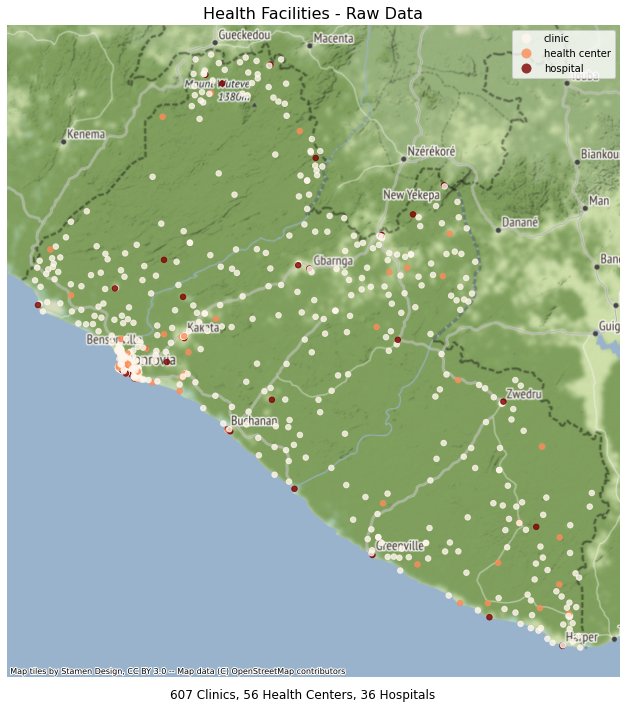

In [41]:
figsize = (12,12)
fig, ax = plt.subplots(1, 1,  figsize = figsize)
ax.set_title("Health Facilities - Raw Data", fontsize=16)
lbr_geo.plot(ax=ax, column='type', legend=True, cmap='OrRd', alpha=0.8, markersize=30)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Terrain, crs='EPSG:4326', zorder=-10)
ax.set_axis_off()
txt="607 Clinics, 56 Health Centers, 36 Hospitals"
plt.figtext(0.5, 0.1, txt, wrap=True, horizontalalignment='center', fontsize=12)

Text(0.5, 0.1, '585 Clinics, 46 Hospitals')

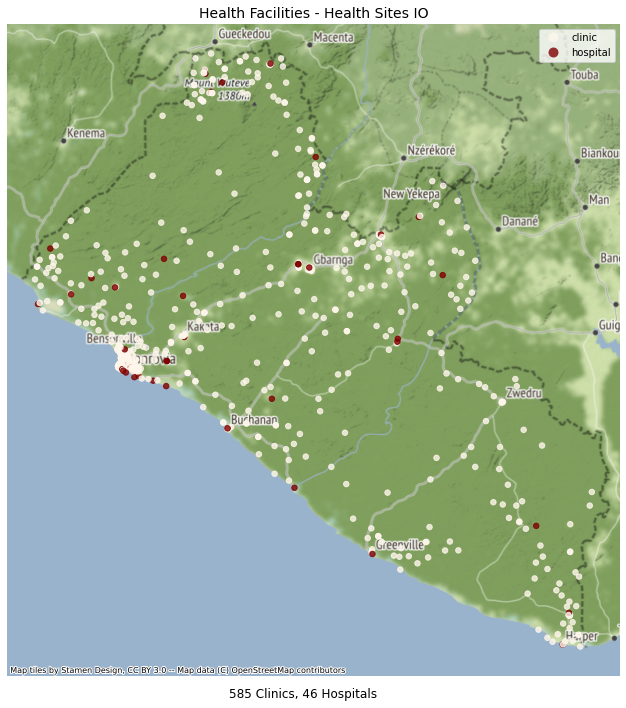

In [42]:
figsize = (12,12)
fig, ax = plt.subplots(1, 1,  figsize = figsize)
ax.set_title("Health Facilities - Health Sites IO", fontsize=14)
lbr_io.plot(ax=ax, column='amenity', legend=True, cmap='OrRd', alpha=0.8, markersize=30)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Terrain, crs='EPSG:4326', zorder=-10)
ax.set_axis_off()
txt="585 Clinics, 46 Hospitals"
plt.figtext(0.5, 0.1, txt, wrap=True, horizontalalignment='center', fontsize=12)